This notebook builds on notebook 18. The purpose of it is to recalculate the times where the guest or the host are speaking.

In [14]:
import pandas as pd

mer = pd.read_json("021_JV_segments_with_metadata.jsonl", orient="records", lines=True)
corp = pd.read_json("020_JV_with_metadata.jsonl", orient="records", lines=True)

def lowercase


In [33]:
i, row = list(mer.iterrows())[3]
SIMILARITY_LIMIT = 80
file = row["file"]
questions = corp.loc[corp.path == file, "host_questions"].tolist()[0]

kaldi_text = row["kaldi_transcript"]
speaker_breakdown = []
is_tagged = "anchor_" in kaldi_text
from fuzzywuzzy.fuzz import partial_ratio
from numpy import argmax
if not is_tagged:
    partial_ratios = [partial_ratio(j, kaldi_text) for j in questions]
    maximal_partial_ratio = max(partial_ratios)

    if maximal_partial_ratio >= SIMILARITY_LIMIT:
        speaker_breakdown.append((
            "host",
            min(row["kaldi_word_starts"]),
            max(row["kaldi_word_ends"])
        ))
        # return speaker_breakdown
else:
    # We have 0 < tags < 6. 
    import re
    parts = re.split(r'<anchor_\w+>',kaldi_text)
    # parts = kaldi_text.split("<anchor_end>", "<anchor_start>")
    maximal_partial_ratios = [
        max([
            partial_ratio(part, question) for question in questions
        ]) for part in parts
    ]
    for part, m in zip(parts, maximal_partial_ratios):
        print(m, " : ", part)
        if m >= SIMILARITY_LIMIT:
            

48  :  znači grad uopšte nije organizovan i mi faktički u gradu nemamo ni jednu jedinu zajedničku želju koju bi trebalo da pokušamo bar da rešimo i da skupštinu iskoristimo za bolji niš i za bolje sutra 
94  :   ali šta je problem zbog čega vi ne možete da se


<AxesSubplot:ylabel='Frequency'>

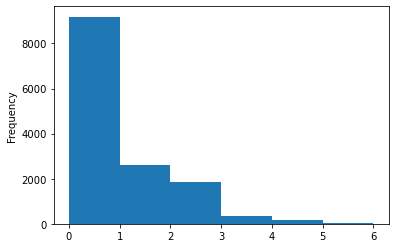

In [22]:
mer.kaldi_transcript.str.count("anchor_").plot.hist(bins=6)

In [31]:
import re
re.split(r'<anchor_\w+>',kaldi_text)

['nikad više',
 ' niti je iskoristio niti će izgleda iskoristi priliku mislim da je to ',
 ' šta je problem',
 ' pa problem je u nama mislim da je problem u gradu nije problem u narodnim poslanicima mi jeste predstavljamo svoje stranke mi nismo birani kao lica mi smo ispred svojih stranaka']